## Create a negative joke dataset

To create a negative joke dataset, jokes will be transformed in a feature matrix of the joke text as word embeddings and other features.

In [1]:
import importlib
import nojokes
import prejokes
from prejokes import JokePreprocessor
import pandas as pd
from sklearn.model_selection import train_test_split 
import statistics 
from statistics import mode
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from nltk.tokenize import sent_tokenize
%matplotlib inline  

## Characteristics and requirements of the negative jokes

The negative jokes should be similar to the real jokes regarding the following features:
* style (narrative, fictional)
* length (number of sentences)
* vocabulary 
* syntactic features (word classes etc.)  

#### Style
In order to collect texts that follow a certain narrative structure, the negative jokes will be drawn from a dataset of American movie plots from Wikipedia.  


#### Length
The movie plots in the dataset are longer than a single joke. To encounter this issue, the following methodology will be applied:
1. Find the average length (number of sentences) in the jokes dataset.
2. Split the movie plot dataset into sentence n-grams according to the determined length


In [ ]:
importlib.reload(prejokes)

In [2]:
jokes_file = '../data/s3_curated_jokes.csv'
jp = JokePreprocessor()
joke_df = jp.load(jokes_file)


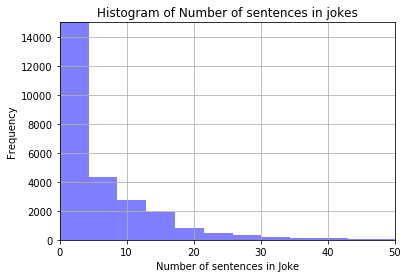

In [3]:
joke_df['Sentence_count'] = joke_df['Joke'].apply(lambda x: jp.count_sentences(x))
sen_count = list(joke_df['Sentence_count'])
num_bins = len(set(sen_count))
#plt.figure(figsize=(100,100))
n, bins, patches = plt.hist(sen_count, num_bins, facecolor='blue', alpha=0.5)
#n, bins, patches = plt.hist(sen_count, num_bins, facecolor='blue', alpha=0.5, normed=1)
plt.xlabel('Number of sentences in Joke')
plt.ylabel('Frequency')
plt.title('Histogram of Number of sentences in jokes')
plt.axis([0, 50, 0, 15000])
plt.grid(True)

plt.show()


#### Average length and median

In [4]:
mean = joke_df['Sentence_count'].mean()
median = joke_df['Sentence_count'].median()

print('Mean: ' + str(mean))
print('Median: ' + str(median))

Mean: 7.106599697938253
Median: 3.0


#### Split movie plot data into sentence n-grams

In [ ]:
jp = JokePreprocessor()
importlib.reload(nojokes)

In [5]:
movieplots_file = '../data/plotdata.txt'
with open(movieplots_file) as file:
    movieplots = file.read().strip().split('\n\n\n\n\n\n')
plot_df = pd.DataFrame(movieplots)
plot_df.columns = ['plot']
plot_df = jp.sentence_n_grams_split(plot_df, 'plot', 6)

In [8]:
# this df holds all sentence ngrams
outfile = '../data/movieplots_6gram.csv'
plot_df.to_csv(outfile)

In [ ]:
df = nojokes.mysql_import('eng_wikipedia_2016_1M','sentences')
df= df.drop([0], axis = 1)
df = df.rename(columns={1:'sentence'})
df = jp.remove_punctuation(df, 'sentence')
df = jp.replace_numbers(df, 'sentence')
df = jp.clean_and_tokenize(df, 'sentence')
df.to_csv(out_file)

In [ ]:
df = pd.from_csv(tokens_file)

#### Filter jokes by number of sentences

In [17]:
outfile = '../data/jokes_6gram.csv'
filtered_jokes = jp.filter_by_joke_len(joke_df, 'Sentence_count', 6)
# this df holds all joke ngrams
filtered_jokes = filtered_jokes['Joke'].reset_index(drop=True)
filtered_jokes.to_csv(outfile)

# Calculate Similarities

In [ ]:
import spacy
# to install the english model, run
# python -m spacy download en

In [ ]:
joke1 = filtered_jokes['Joke'][11]
joke1=nlp(joke1)

In [ ]:
nlp = spacy.load('en')

In [ ]:
similarity_df = plot_df
similarity_df['Vector'] = similarity_df['joke_ngram'].apply(lambda x: nlp(x))


In [ ]:
similarity_df['Joke1_sim'] = similarity_df['Vector'].apply(lambda x: x.similarity(joke1))

In [ ]:
max_value = similarity_df['Joke1_sim'].values.argmax()
most_similar_text = similarity_df['joke_ngram'][max_value]
most_similar_text

In [ ]:
joke1